In [1]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import os, time, stat, io, glob, pickle
from scipy.stats import gamma, norm

from covid_data_helper import *
from coronita_model_helper_test import *
%load_ext autoreload
%autoreload 2

In [2]:
## DATA INGESTION ##

df_st_testing = get_covid19_tracking_data()

df_census = get_census_pop()

df_counties = get_complete_county_data()

counties_geo = get_counties_geo()

df_jhu_counties = get_jhu_counties()

df_st_testing_fmt = df_st_testing.copy()
df_st_testing_fmt = df_st_testing_fmt.rename(columns={'death':'deaths','positive':'cases'}).unstack('code')

df_interventions = get_state_policy_events()

df_goog_mob_us = get_goog_mvmt_us()
df_goog_mob_state = get_goog_mvmt_state(df_goog_mob_us)
df_goog_mob_us = df_goog_mob_us[df_goog_mob_us.state.isnull()].set_index('dt')

#######################

State Testing Data Last Observation:  20201007
Got COVID19 Tracking Data
Got Census Data
Got NYS DOH data
Got Census Data
Got NYT county level data.
Got Google Movement Data
Got Complete County Data
Got counties geo json
Got JHU county level data.
Got KFF Policy dates
Got Google Movement Data


In [3]:
# l_states_to_fore = df_census.state.unique()
l_states_to_fore = ['NY']

In [4]:
## MODEL PARAMETERS ##

covid_params = {}
covid_params['d_incub'] = 3.
covid_params['d_infect'] = 4.
covid_params['mort_rt'] = 0.01
covid_params['d_in_hosp'] = 11
covid_params['hosp_rt'] = 0.04
covid_params['d_to_hosp'] = 7.0
covid_params['d_in_hosp_mild'] = 11.0
covid_params['icu_rt'] = 13./41.
covid_params['d_in_icu'] = 13.0
covid_params['vent_rt'] = 0.4
covid_params['d_til_death'] =  17.0
covid_params['policy_trigger'] = True
covid_params['policy_trigger_once'] = True
days_to_forecast = 150

#######################


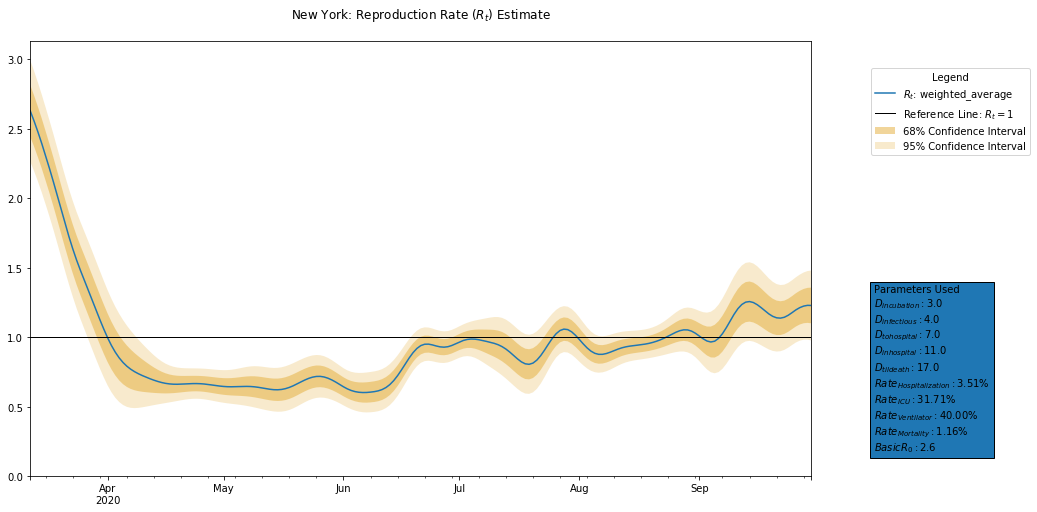

In [7]:
from coronita_chart_helper import ch_rt_confid

model_dict = make_model_dict_state('NY',abbrev_us_state,df_census,
    df_st_testing_fmt,
    covid_params,
    d_to_forecast=75,
    df_mvmt=df_goog_mob_state)
ax = ch_rt_confid(model_dict)


2020-09-30 00:00:00


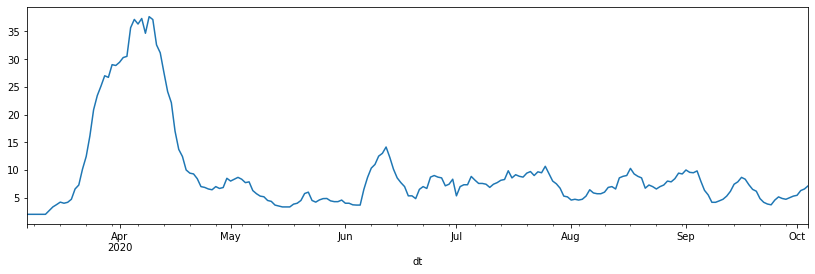

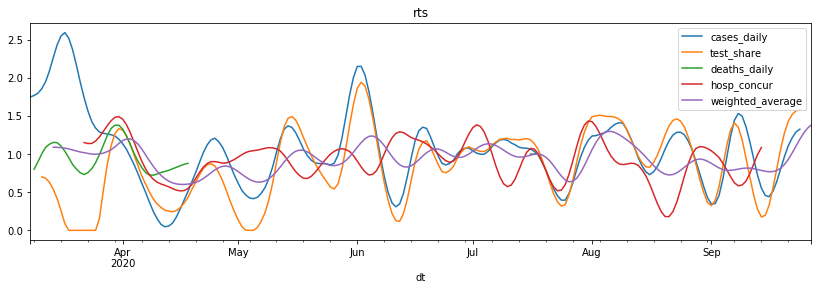

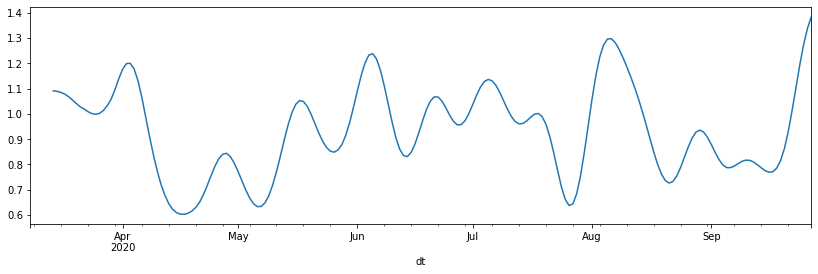

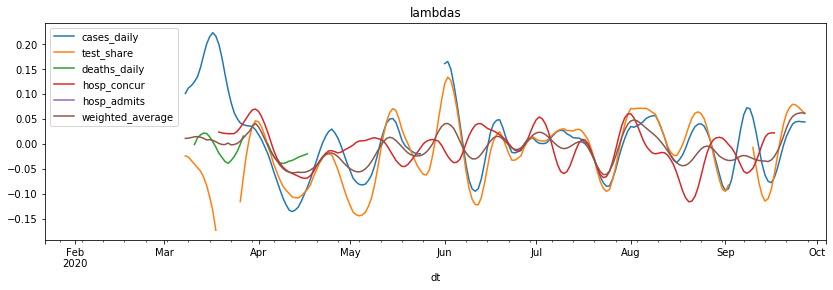

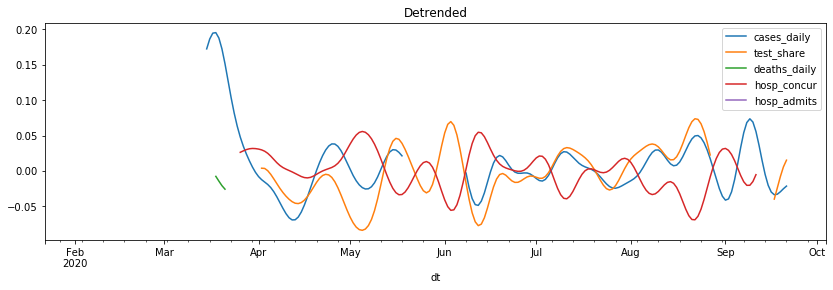

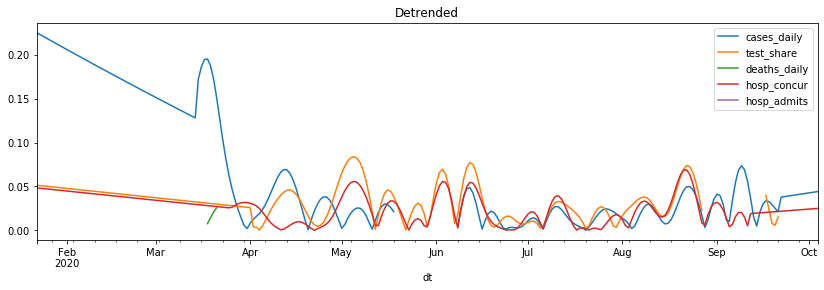

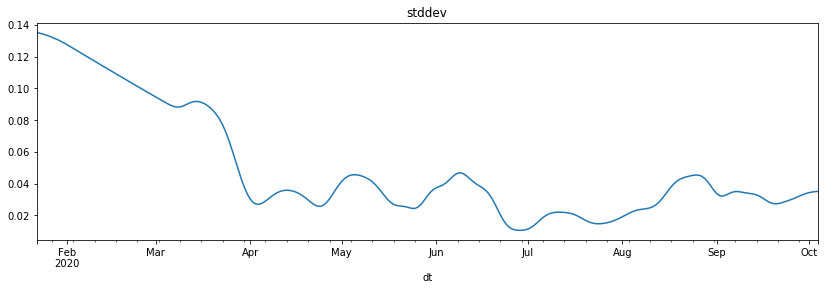

Text(0.5, 0, '')

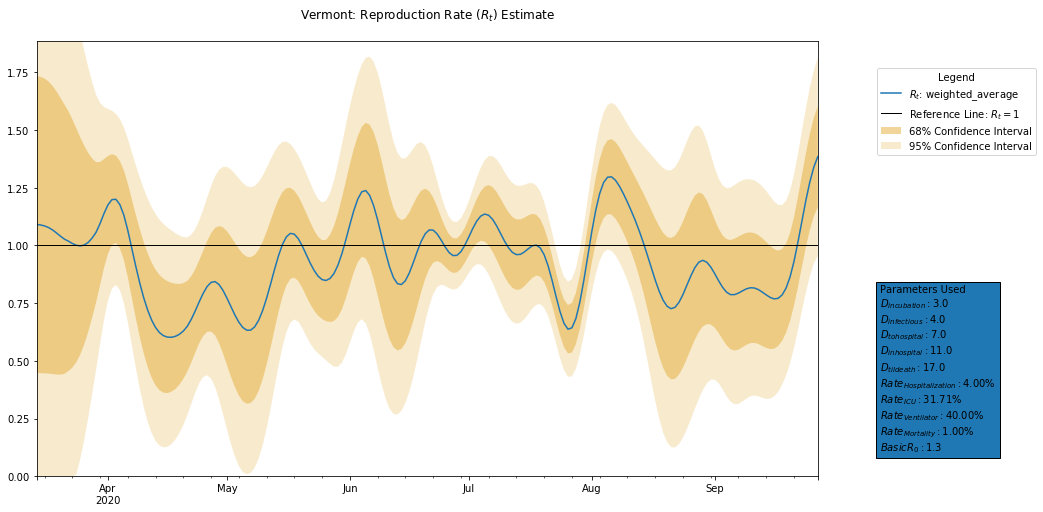

In [534]:
df_hist = model_dict['df_hist'].copy()
df_hist = df_hist.dropna(how='all', axis=1)
df_hist = df_hist[[col for col in df_hist.columns if df_hist[col].std()>0]]

keepcols = []
lookback = 7
d_infect = model_dict['covid_params']['d_infect'] + model_dict['covid_params']['d_incub']
_gamma = 1 / d_infect

df_weights = pd.DataFrame(index=df_hist.index)
df_hist_shifted = pd.DataFrame(index=df_hist.index)
df_lambdas = pd.DataFrame(index=df_hist.index)
df_rts_conf = pd.DataFrame()

if 'cases_daily' in df_hist.columns:
    keepcols.append('cases_daily')
    df_weights['cases_daily'] = 0.5
    cases_shift = int(model_dict['covid_params']['d_incub'] + 2) * -1
    
    cases_daily = df_hist['cases_daily']
    cases_daily = outlier_removal(cases_daily, num_std=4).add(1.0)
    cases_daily = cases_daily.rolling(lookback, center=False, min_periods=1).mean()
    df_hist_shifted['cases_daily'] = cases_daily.shift(cases_shift)
    
    df_rt = est_rt_wconf(df_hist_shifted['cases_daily'], lookback, d_infect)
    df_rts_conf = pd.concat([df_rts_conf, df_rt.stack('metric')], axis=1)

if ('cases_daily' in df_hist.columns) and ('pos_neg_tests_daily' in df_hist.columns):
    keepcols.append('test_share')
    df_weights['test_share'] = 1.0
    test_share_shift = int(model_dict['covid_params']['d_incub'] + 2) * -1
    
    cases_daily_7da = outlier_removal(df_hist['cases_daily']).add(1.0)
    cases_daily_7da = cases_daily_7da.rolling(lookback, center=False, min_periods=1).mean()
    pos_neg_tests_7da = outlier_removal(model_dict['df_hist']['pos_neg_tests_daily']).add(1.0)
    pos_neg_tests_7da = pos_neg_tests_daily.rolling(lookback, center=False, min_periods=1).mean()
    
    test_share = cases_daily_7da.div(pos_neg_tests_7da)

    test_share = test_share.replace([np.inf, -np.inf], np.nan)
    test_share = test_share.mask(test_share >= 1)
    test_share = test_share.mask(test_share >= 0.4)
    test_share = test_share.clip(upper=1.0, lower=0.0)
    df_hist_shifted['test_share'] = test_share.shift(test_share_shift)
    
    df_rt = est_rt_wconf(df_hist_shifted['test_share'], lookback, d_infect)
    df_rts_conf = pd.concat([df_rts_conf, df_rt.stack('metric')], axis=1)

if 'deaths_daily' in df_hist.columns:
    keepcols.append('deaths_daily')
    df_weights['deaths_daily'] = 3.0
    deaths_shift = int(model_dict['covid_params']['d_incub'] + model_dict['covid_params']['d_til_death']) * -1
    
    deaths_daily = df_hist['deaths_daily']
    deaths_daily = outlier_removal(deaths_daily, num_std=4).add(1.0)
    deaths_daily = deaths_daily.rolling(lookback, center=False, min_periods=1).mean()
    df_hist_shifted['deaths_daily'] = deaths_daily.shift(deaths_shift)
    
    df_rt = est_rt_wconf(df_hist_shifted['deaths_daily'], lookback, d_infect)
    df_rts_conf = pd.concat([df_rts_conf, df_rt.stack('metric')], axis=1)

if 'hosp_concur' in df_hist.columns:
    keepcols.append('hosp_concur')
    df_weights['hosp_concur'] = 1.5
    hosp_concur_shift =  ( int(model_dict['covid_params']['d_incub']
                               + model_dict['covid_params']['d_to_hosp']
                               + model_dict['covid_params']['d_in_hosp'] / 2)
                          * -1)
    
    hosp_concur = df_hist['hosp_concur']
    hosp_concur = outlier_removal(hosp_concur, num_std=4).add(1.0)
    hosp_concur = hosp_concur.rolling(lookback, center=False, min_periods=1).mean()
    df_hist_shifted['hosp_concur'] = hosp_concur.shift(hosp_concur_shift)
    
    df_rt = est_rt_wconf(df_hist_shifted['hosp_concur'], lookback, d_infect)
    df_rts_conf = pd.concat([df_rts_conf, df_rt.stack('metric')], axis=1)

if 'hosp_admits' in df_hist.columns:
    keepcols.append('hosp_admits')
    df_weights['hosp_admits'] = 3.0
    hosp_admits_shift =  ( int(model_dict['covid_params']['d_incub']
                               + model_dict['covid_params']['d_to_hosp'])
                          * -1)

    if 'hosp_concur' in df_hist.columns:
        df_hist.loc[df_hist['hosp_admits'] < df_hist['hosp_concur'].diff(), 'hosp_admits'] = np.nan
    
    hosp_admits = df_hist['hosp_admits']
    hosp_admits = outlier_removal(hosp_admits, num_std=4).add(1.0)
    hosp_admits = hosp_admits.rolling(lookback, center=False, min_periods=1).mean()
    df_hist_shifted['hosp_admits'] = hosp_admits.shift(hosp_admits_shift)
    
    df_rt = est_rt_wconf(df_hist_shifted['hosp_admits'], lookback, d_infect)
    df_rts_conf = pd.concat([df_rts_conf, df_rt.stack('metric')], axis=1)

df_hist_shifted_ravg = df_hist_shifted.rolling(lookback, win_type='gaussian', center=True, min_periods=3).mean(std=3)
print(df_hist_shifted_ravg.last_valid_index())
df_lambdas = df_hist_shifted_ravg.copy()
df_lambdas = df_lambdas.pct_change(fill_method=None)
# df_lambdas = df_lambdas.apply(np.log).diff()
df_lambdas = df_lambdas.replace([np.inf, -np.inf], np.nan)
df_lambdas = df_lambdas.apply(outlier_removal, num_std=3)

df_lambdas = df_lambdas.rolling(lookback, win_type='gaussian', center=True).mean(std=4)

for center in df_lambdas.dropna(how='all').index:
    bow = center - pd.Timedelta(days=(lookback-1)//2)
    eow = center + pd.Timedelta(days=(lookback-1)//2)
    windowed = np.array(df_lambdas.loc[bow:eow, keepcols].to_numpy()).flatten()
    windowed = windowed[~np.isnan(windowed)]
    weights = df_weights[~df_lambdas[keepcols].isnull()].loc[bow:eow, keepcols].to_numpy().flatten()
    weights = weights[~np.isnan(weights)]

    if windowed.shape[0] > 0:
        weighted_stats = DescrStatsW(windowed, weights=weights, ddof=0)
        df_lambdas.loc[center, 'weighted_average'] = weighted_stats.mean

###### Detrended Std Deviation ######
std_lookback = lookback*2
df_detrended = df_lambdas[keepcols].sub(df_lambdas['weighted_average'], axis=0)
df_detrended = df_detrended.rolling(std_lookback, win_type='gaussian', center=True).mean(std=2)
df_detrended_abs = df_detrended.apply(np.abs)
df_detrended_abs_ffill = df_detrended_abs.apply(
    lambda x: 
    x.rolling(std_lookback).mean().loc[x.last_valid_index():].fillna(method='ffill')\
    .div(len(df_detrended.columns)*std_lookback).add(1).cumprod().sub(1).add(
        x.dropna().iloc[-1*std_lookback:].mean())
)
df_detrended_abs_bfill = df_detrended_abs.apply(
    lambda x: 
    x.rolling(std_lookback).mean().fillna(method='bfill').loc[:x.first_valid_index()][::-1]\
    .div(len(df_detrended.columns)*std_lookback).add(1).cumprod().sub(1).add(
        x.dropna().iloc[:std_lookback].mean())
)
df_detrended_abs = df_detrended_abs.fillna(df_detrended_abs_ffill).fillna(df_detrended_abs_bfill)
# df_detrended_abs = df_detrended_abs.interpolate()

stddev = df_detrended_abs.apply(np.square).rolling(std_lookback, center=True, min_periods=1).sum().sum(axis=1).div(
    df_detrended_abs.count(axis=1).rolling(std_lookback, center=True, min_periods=1).sum().sub(1)).apply(np.sqrt)

stddev = stddev.rolling(std_lookback, win_type='gaussian', center=True, min_periods=1).mean(std=2)

stddev = stddev.fillna(method='ffill').fillna(method='bfill')
#####################################

s_lambda = df_lambdas['weighted_average']
s_lambda = s_lambda.rolling(lookback, win_type='gaussian', center=False).mean(std=3)

s_lambda = s_lambda.loc[:s_lambda.last_valid_index()]
s_lambda = s_lambda.clip(lower=-1.0)

s_beta = s_lambda.add(_gamma).clip(lower=0.0)

df_rt = pd.DataFrame(s_beta.div(_gamma))
df_rt.columns = ['rt']

df_rt['rt_u68'] = s_lambda.add(stddev.mul(1)).add(_gamma).clip(lower=0.0).div(_gamma)
df_rt['rt_l68'] = s_lambda.sub(stddev.mul(1)).clip(lower=-1.0).add(_gamma).clip(lower=0).div(_gamma)
df_rt['rt_u95'] = s_lambda.add(stddev.mul(1.96)).add(_gamma).clip(lower=0.0).div(_gamma)
df_rt['rt_l95'] = s_lambda.sub(stddev.mul(1.96)).clip(lower=-1.0).add(_gamma).clip(lower=0).div(_gamma)
df_rt.columns.name = 'metric'
df_rt = pd.DataFrame(df_rt.stack(), columns=['weighted_average']).unstack()

df_rts_conf = pd.concat([df_rts_conf, df_rt.stack('metric')], axis=1)

cases_daily.dropna().plot(figsize=[14,4]); plt.show()
df_rts_conf.unstack('metric').swaplevel(axis=1)['rt'].plot(figsize=[14,4], title='rts'); plt.show()
df_rts_conf.unstack('metric').swaplevel(axis=1)['rt']['weighted_average'].plot(figsize=[14,4]); plt.show()
df_lambdas.plot(figsize=[14,4], title='lambdas'); plt.show()
df_detrended.plot(title='Detrended', figsize=[14,4]); plt.show()
df_detrended_abs.plot(title='Detrended', figsize=[14,4]); plt.show()
stddev.plot(title='stddev', figsize=[14,4]); plt.show()

df_rt = df_rts_conf[['weighted_average']].unstack('metric')
param_str = param_str_maker(model_dict)
rt_name = df_rt.columns.levels[0][0]
df_rt = df_rt[rt_name].dropna(how='all')

ax = df_rt['rt'].dropna(how='all').plot(figsize=[14, 8],
                                 title=model_dict['region_name']+r': Reproduction Rate ($R_{t}$) Estimate'+'\n'+model_dict['chart_title'],
                                 legend=True,
                                        label='$R_t$: {}'.format(rt_name))
ci68 = plt.fill_between(df_rt['rt_u68'].index, df_rt['rt_u68'], df_rt['rt_l68'],
                        alpha=0.5, facecolor='#e5ae38', label='68% Confidence Interval')
ci95 = plt.fill_between(df_rt['rt_u95'].index, df_rt['rt_u95'], df_rt['rt_l95'],
                        alpha=0.25, facecolor='#e5ae38', label='95% Confidence Interval')
ax.set_ylim([0,df_rt['rt'].max()+0.5])
ax.set_xlim([df_rt['rt'].dropna().index.min(), df_rt['rt'].dropna().index.max()])

ref_line = df_rt['rt'].dropna().copy()
ref_line.loc[:] = 1.0
ref_line.plot(ax=ax, color=['black'], legend=True, linewidth=1, label='Reference Line: $R_t = 1$')
plt.legend(title='Legend', loc='upper left', bbox_to_anchor=(1.07, 0.95), ncol=1)

ax.text(1.08, 0.05, param_str, transform=ax.transAxes,
        verticalalignment='bottom', bbox={'ec': 'black', 'lw': 1})
ax.set_xlabel('')

# plt.annotate(model_dict['footnote_str'],
#              (0, 0), (0, -80), xycoords='axes fraction', textcoords='offset points', va='top')

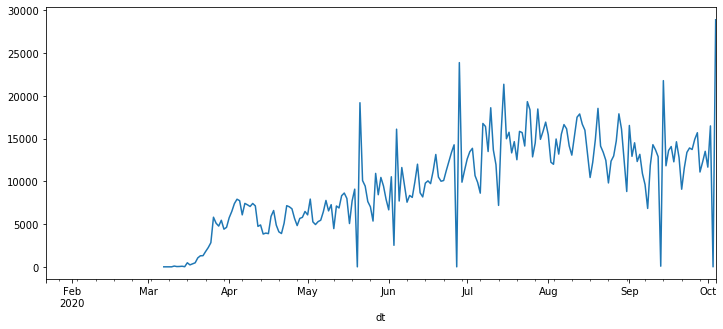

In [508]:
thisvar= 'pos_neg_tests_daily' #'deaths_daily'

df_hist[thisvar].loc[:].plot(figsize=[12,5])
# df_hist_shifted[thisvar].loc[:].plot()
# df_hist_shifted_ravg[thisvar].loc[:].plot()


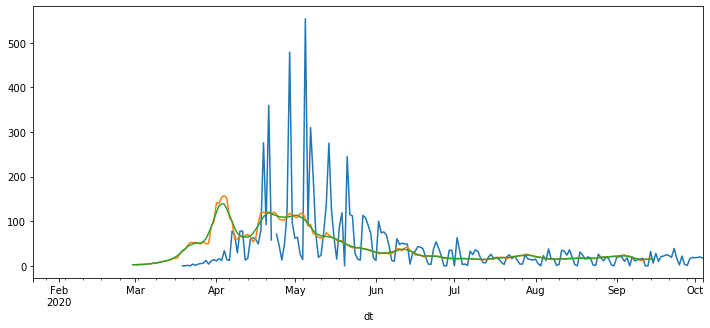

In [509]:
thisvar= 'deaths_daily'

df_hist[thisvar].loc[:].plot(figsize=[12,5])
df_hist_shifted[thisvar].loc[:].plot()
df_hist_shifted_ravg[thisvar].loc[:].plot()


dt
2020-09-30    1153.0
2020-10-01    1156.0
2020-10-02    1161.0
2020-10-03       0.0
2020-10-04    2251.0
Name: cases_daily, dtype: float64

dt
2020-09-26     954.809567
2020-09-27     974.746240
2020-09-28     992.539302
2020-09-29    1007.120267
2020-09-30    1017.704659
Name: cases_daily, dtype: float64

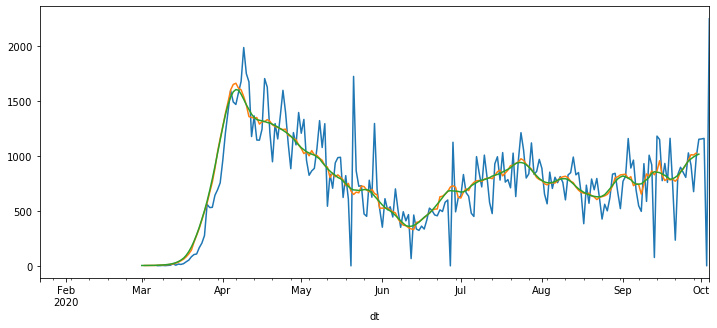

In [510]:
thisvar= 'cases_daily' #'deaths_daily'

df_hist[thisvar].loc[:].plot(figsize=[12,5])
df_hist_shifted[thisvar].loc[:].plot()
df_hist_shifted_ravg[thisvar].loc[:].plot()
display(df_hist[thisvar].dropna().tail())
display(df_hist_shifted_ravg[thisvar].dropna().tail())


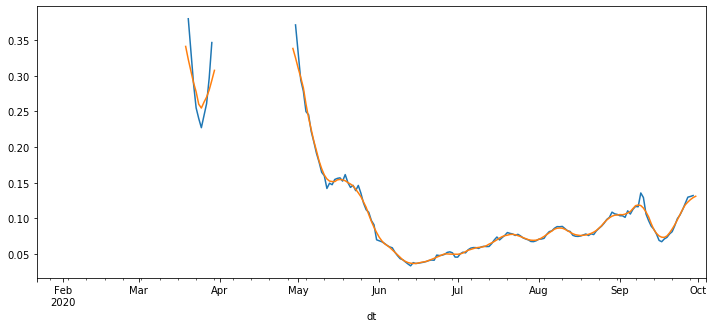

In [511]:
thisvar= 'test_share' #'deaths_daily'

# df_hist[thisvar].loc[:].plot(figsize=[12,5])
df_hist_shifted[thisvar].loc[:].plot(figsize=[12,5])
df_hist_shifted_ravg[thisvar].loc[:].plot()


dt
2020-03-06    0.0
2020-03-07    0.0
2020-03-08    0.0
2020-03-09    0.0
2020-03-10    0.0
             ... 
2020-09-13    0.0
2020-09-17    0.0
2020-09-19    0.0
2020-09-20    0.0
2020-09-23    0.0
Name: hosp_admits, Length: 138, dtype: float64

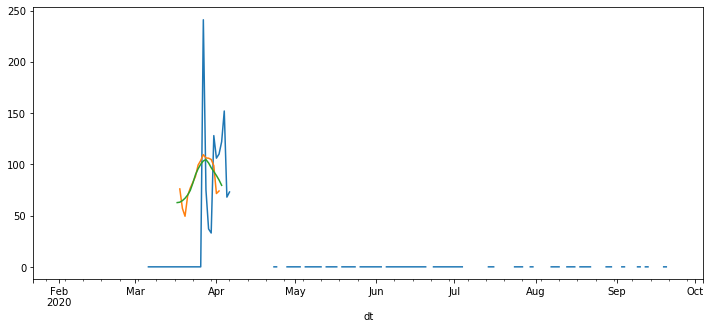

In [514]:
thisvar= 'hosp_admits' #'deaths_daily'

df_hist[thisvar].loc[:].plot(figsize=[12,5])
df_hist_shifted[thisvar].loc[:].plot()
df_hist_shifted_ravg[thisvar].loc[:].plot()
df_hist[thisvar].dropna()


dt
2020-04-07    1665.0
2020-04-08    1898.0
2020-04-09    2051.0
2020-04-10    2072.0
2020-04-11    2115.0
               ...  
2020-09-30     539.0
2020-10-01     558.0
2020-10-02     561.0
2020-10-03     573.0
2020-10-04     603.0
Name: hosp_concur, Length: 181, dtype: float64

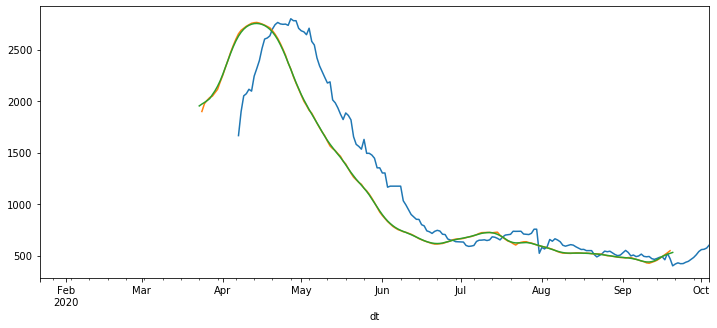

In [515]:
thisvar= 'hosp_concur' #'deaths_daily'

df_hist[thisvar].loc[:].plot(figsize=[12,5])
df_hist_shifted[thisvar].loc[:].plot()
df_hist_shifted_ravg[thisvar].loc[:].plot()
df_hist[thisvar].dropna()

